In [1]:
import torch

In [2]:
import torchvision

In [3]:
torch.cuda.is_available()

True

In [4]:
import numpy as np

In [5]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)#, parser='auto')
X = X.values

X = X / 255. #normalization to [0,1]

y = X

print(X.shape)
print(y.shape)

(70000, 784)
(70000, 784)


In [6]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123)

del X_temp, y_temp, X, y

In [7]:
X_train, X_valid, X_test, y_train, y_valid, y_test = torch.from_numpy(X_train.astype(np.float32)), torch.from_numpy(X_valid.astype(np.float32)), torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_train.astype(np.float32)), torch.from_numpy(y_valid.astype(np.float32)), torch.from_numpy(y_test.astype(np.float32))

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import t

In [9]:
##########################
### t_prior_VAE
##########################
class t_prior_VAE(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, latent_size, df):
        super().__init__()
        self.fce1 = nn.Linear(input_size, hidden_size1)
        self.fce2 = nn.Linear(hidden_size1, hidden_size2)
        self.fce3_mu = nn.Linear(hidden_size2, latent_size)
        self.fce3_logvar = nn.Linear(hidden_size2, latent_size)
        
        self.fcd1 = nn.Linear(latent_size, hidden_size2)
        self.fcd2 = nn.Linear(hidden_size2, hidden_size1)
        self.fcd3 = nn.Linear(hidden_size1, input_size)

        self.df = df # degree of freedom of prior t-distribution

    def encoder(self, x):
        z_e1 = self.fce1(x)
        a_e1 = F.relu(z_e1) # activation

        z_e2 = self.fce2(a_e1)
        a_e2 = F.relu(z_e2) # activation
        
        mu = self.fce3_mu(a_e2)
        logvar = self.fce3_logvar(a_e2)
        
        return z_e1, a_e1, z_e2, a_e2, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.from_numpy(t.rvs(df=self.df, size=mu.shape).astype(np.float32)) # student's t iid matrix with degree of freedom v
        
        latent = mu + eps * std
        
        return latent, eps
        
    def decoder(self, latent):
        z_d1 = self.fcd1(latent)
        a_d1 = F.relu(z_d1) # activation
        
        z_d2 = self.fcd2(a_d1)
        a_d2 = F.relu(z_d2) # activation

        z_d3 = self.fcd3(a_d2)
        recon_x = torch.sigmoid(z_d3) # sigmoid
    
        return z_d1, a_d1, z_d2, a_d2, recon_x
        
    def forward(self, x):
        z_e1, a_e1, z_e2, a_e2, mu, logvar = self.encoder(x)
        latent, eps = self.reparameterize(mu, logvar)
        z_d1, a_d1, z_d2, a_d2, recon_x = self.decoder(latent)
        
        return z_e1, a_e1, z_e2, a_e2, mu, logvar, latent, z_d1, a_d1, z_d2, a_d2, recon_x, eps

In [10]:
def loss_function(recon_x, x, mu, logvar, latent, df):
    RCE = F.binary_cross_entropy(recon_x, x, reduction = 'sum')
    # RCE = -torch.sum(x * torch.log(recon_x) + (1 - x) * torch.log(1 - recon_x))
    KLD = torch.sum(-0.5 * logvar + 0.5 * (df + 1) * (torch.log(1 + 1 / df * torch.pow(latent, 2)) - torch.log(1 + 1 / df * torch.pow(((latent - mu) / torch.exp(0.5 * logvar)), 2))))
    return RCE, KLD

In [11]:
def train(model, train_dl, valid_dl, optimizer, epochs):
    
    train_loss_his = torch.zeros(epochs)
    valid_loss_his = torch.zeros(epochs)
    
    for epoch in range(epochs):
        
        train_loss = 0
        for i, (x, _) in enumerate(train_dl):

            _, _, _, _, mu, logvar, latent, _, _, _, _, recon_x, _ = model(x)

            RCE, KLD = loss_function(recon_x, x, mu, logvar, latent, model.df)
            loss = RCE + KLD

            loss.backward()

            train_loss += loss
        
            optimizer.step()
            optimizer.zero_grad()

            # if i % 20 == 0: print(f'Train Epochs: {epoch+1} [{i*len(x)}/{len(train_dl.dataset)}] loss: {loss / len(x)}')
        
        valid_loss = 0
        for (v, _) in valid_dl:
            
            _, _, _, _, mu_v, logvar_v, latent_v, _, _, _, _, recon_v, _ = model(v)
            
            RCE_v, KLD_v = loss_function(recon_v, v, mu_v, logvar_v, latent_v, model.df)
            loss_v = RCE_v + KLD_v

            valid_loss += loss_v

        train_loss_his[epoch] = train_loss / len(train_dl.dataset)
        valid_loss_his[epoch] = valid_loss / len(valid_dl.dataset)
        
        print(f'Epochs: {epoch+1}/{epochs} | Train loss: {train_loss / len(train_dl.dataset)} | Valid loss: {valid_loss / len(valid_dl.dataset)}')

    return train_loss_his, valid_loss_his

In [12]:
df = 21
model=t_prior_VAE(28*28, 400, 128, 10, df)

In [13]:
epochs=300
batch_size=500
learning_rate=0.005/batch_size

In [14]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [15]:
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
valid_ds = TensorDataset(X_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=True)
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [16]:
optimizer=torch.optim.SGD(model.parameters(), lr = learning_rate)

In [17]:
train_loss_his, valid_loss_his = train(model, train_dl, valid_dl, optimizer, epochs)

Epochs: 1/300 | Train loss: 242.59548950195312 | Valid loss: 204.7555694580078
Epochs: 2/300 | Train loss: 201.0108184814453 | Valid loss: 199.21617126464844
Epochs: 3/300 | Train loss: 195.99984741210938 | Valid loss: 194.86439514160156
Epochs: 4/300 | Train loss: 193.04978942871094 | Valid loss: 191.81011962890625
Epochs: 5/300 | Train loss: 190.64529418945312 | Valid loss: 190.93605041503906
Epochs: 6/300 | Train loss: 187.8052215576172 | Valid loss: 186.10719299316406
Epochs: 7/300 | Train loss: 184.65890502929688 | Valid loss: 182.67056274414062
Epochs: 8/300 | Train loss: 181.4092254638672 | Valid loss: 179.68310546875
Epochs: 9/300 | Train loss: 176.97317504882812 | Valid loss: 175.30189514160156
Epochs: 10/300 | Train loss: 173.6178436279297 | Valid loss: 172.47584533691406
Epochs: 11/300 | Train loss: 171.0446319580078 | Valid loss: 170.2777557373047
Epochs: 12/300 | Train loss: 168.72177124023438 | Valid loss: 169.02133178710938
Epochs: 13/300 | Train loss: 164.345703125 | Va

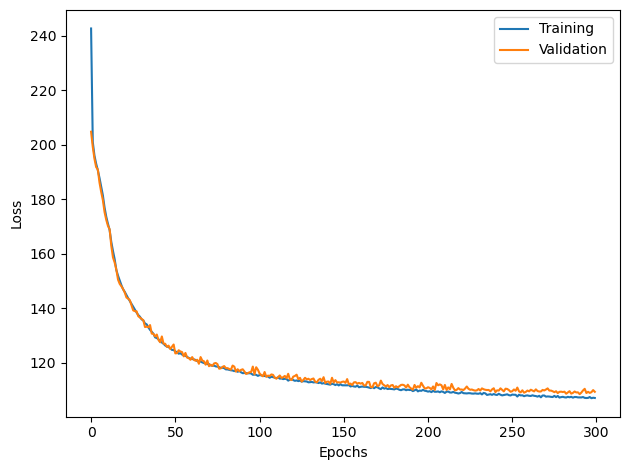

In [18]:
import matplotlib.pyplot as plt

train_loss_his, valid_loss_his = train_loss_his.detach().numpy(), valid_loss_his.detach().numpy()
plt.plot(range(len(train_loss_his)), train_loss_his,
         label='Training')
plt.plot(range(len(valid_loss_his)), valid_loss_his,
         label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [19]:
np.random.seed(123)
n=np.random.randint(0,10000,10)
n # test data index

array([3582, 1346, 5218, 7763, 9785, 7382, 5857,   96, 6257, 6782])

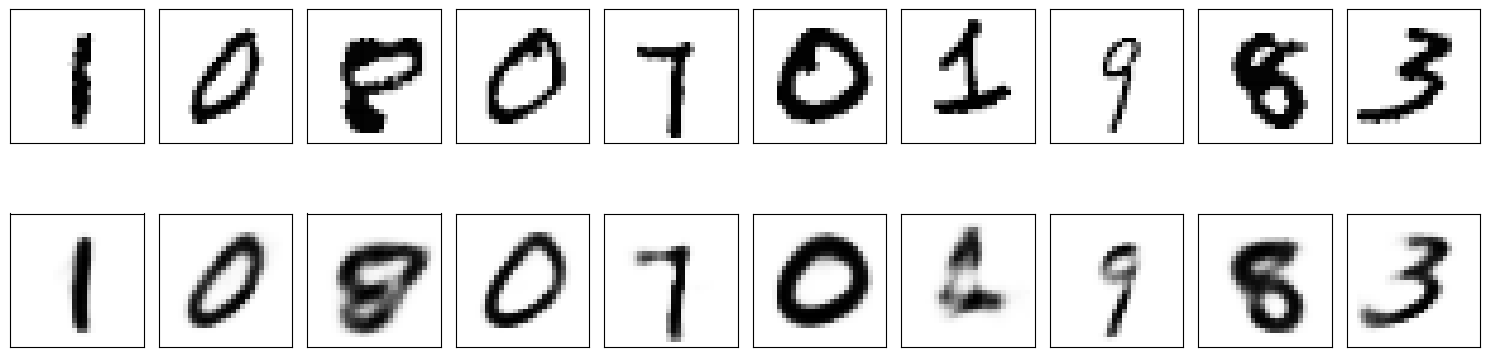

In [20]:
# true & reconstructed

fig, ax = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(15,5))
ax = ax.flatten()

for i in range(len(n)):
    img = X_test[n[i],:].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
for j in range(len(n)):
    _, _, _, _, _, _, _, _, _, _, _, pred, _ = model(X_test[n[j],:])
    img = pred.detach().numpy().reshape(28, 28)
    ax[j+10].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()